# Imports

In [1]:
%load_ext autoreload
%autoreload 2

print("Loading imports...")
from config import *

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data analysis
import glob
import os
import sys
from datetime import datetime, timedelta
import copy
import cftime

# Plotting
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal as signal
from scipy.stats import t
import xarray as xr
xr.set_options(keep_attrs=True)
import xrft

# Cartopy
from cartopy import crs as ccrs
from cartopy import feature as cf
from cartopy import util as cutil
from matplotlib import colors as mcolors
from matplotlib import ticker as mticker
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from plotting_functions import *
from matplotlib.animation import FuncAnimation

# import colormaps as cmaps
sys.path.insert(0, "/glade/u/home/sressel/auxiliary_functions/")
import mjo_mean_state_diagnostics as mjo
from bmh_colors import bmh_colors
from one_two_one_filter import one_two_one_filter
from rounding_functions import round_out
from tick_labeller import tick_labeller
from load_aquaplanet_data import load_aquaplanet_data
from standardize_data import standardize_data
from processing_functions import *

print("Imports loaded")

Loading imports...
Imports loaded


# Specify analysis parameters

In [2]:
# Set latitude bounds
LATITUDE_SOUTH = -30
LATITUDE_NORTH = 30
latitude_subset_bounds = slice(LATITUDE_SOUTH, LATITUDE_NORTH)

# Set central longitude
CENTRAL_LONGITUDE = 0

# Set longitude bounds
LONGITUDE_MIN = 0
LONGITUDE_MAX = 360

# Set time bounds
missing_days = [
    cftime.DatetimeNoLeap(7, 2, 5, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 6, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 7, 0, 0, 0, 0, has_year_zero=True),
]

START_TIME = cftime.DatetimeNoLeap(3, 1, 3, 0, 0, 0, 0, has_year_zero=True)
END_TIME = cftime.DatetimeNoLeap(13, 1, 3, 0, 0, 0, 0, has_year_zero=True)
first_half_subset_bounds = slice(START_TIME, missing_days[0] - timedelta(days=1))
second_half_subset_bounds = slice(missing_days[-1] + timedelta(days=1), END_TIME)

# Cut-off periods for intraseasonal filtering
INTRASEASONAL_LOWCUT = 100
INTRASEASONAL_HIGHCUT = 20
frequency_subset_bounds = slice(INTRASEASONAL_LOWCUT, INTRASEASONAL_HIGHCUT)

# Cut-off wavenumbers for MJO-filtering
LARGE_SCALE_CUTOFF = 1
SMALL_SCALE_CUTOFF = 3
wavenumber_bounds = slice(LARGE_SCALE_CUTOFF, SMALL_SCALE_CUTOFF)

# Column-integrated bounds
LOWER_LEVEL_PRESSURE = 950
UPPER_LEVEL_PRESSURE = 100
pressure_subset_bounds = slice(UPPER_LEVEL_PRESSURE, LOWER_LEVEL_PRESSURE)

# Load data

In [3]:
reload_variables = False

# experiment_to_load = '4K'
variables_to_load = [
    "Precipitation",
    # "Outgoing Longwave Radiation",
    "Zonal Wind",
    "Meridional Wind",
    "Vertical Wind",
    # "Temperature",
    # "Moisture",
    # "Relative Humidity",
    # "Geopotential Height",
    # "Longwave Heating Rate",
    # "Shortwave Heating Rate",
    # "Latent Heat Flux",
    # "Sensible Heat Flux",
    # "Surface Pressure",
    # "Moist Static Energy",
    # "Column Moist Static Energy",
    # "Column Water Vapor",
    # "Column Temperature",
    # "Column Longwave Heating",
    # "Column Shortwave Heating"
    # "Potential Temperature",
    # "Saturation Specific Humidity"
    "Column Relative Humidity"
]

# if reload_variables or 'variables_dict' not in globals():
#     variables_dict = load_aquaplanet_data(variables_to_load, experiment_to_load)
# else:
#     new_variables_dict = load_aquaplanet_data(variables_to_load, experiment_to_load)

#     # If not reloading, append new variables to existing dict
#     for variable_name, variable_data in new_variables_dict.items():
#         if variable_name not in variables_dict.keys():
#             print(f"Adding {variable_name} to Active Variables...", end="")
#             variables_dict[variable_name] = variable_data
#             print(rf"{'✔':>1}")

# print('=' * str_width)
# print(f"\nActive Variables:")
# print("\n".join([key for key in variables_dict.keys()]))

# Process data

The data has to be subset in two halves, because there are three days without data in the middle of the dataset

## Load existing processed data

### Subset data

In [4]:
multi_experiment_variables_subset = load_multi_experiment_subset_data(variables_to_load, {}, False)

          Loading subset data           
(1/5) Precipitation...                  
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(2/5) Zonal Wind...                     
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(3/5) Meridional Wind...                
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(4/5) Vertical Wind...                  
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                

In [5]:
zonal_wind_meridional_gradient = multi_experiment_variables_subset['Zonal Wind'].differentiate('lat')/EARTH_RADIUS
meridional_wind_zonal_gradient = multi_experiment_variables_subset['Meridional Wind'].differentiate('lon')/(EARTH_RADIUS*np.cos(np.deg2rad(multi_experiment_variables_subset['Meridional Wind'].lat)))
relative_vorticity = meridional_wind_zonal_gradient - zonal_wind_meridional_gradient
# relative_vorticity = vorticity.copy(deep=True)
relative_vorticity.name = 'Relative Vorticity'
relative_vorticity.attrs['units'] = r's$^{-1}$'
relative_vorticity.attrs['short_name'] = 'ζ'
relative_vorticity.attrs['file_id'] = 'vorticity'

In [12]:
EARTH_ROTATION_RATE = 7.2921*10**-5
planetary_vorticity = 2*EARTH_ROTATION_RATE*np.sin(np.deg2rad(relative_vorticity.lat))

In [14]:
vortex_stretching = -(0.01*multi_experiment_variables_subset['Vertical Wind'].differentiate('plev'))*(relative_vorticity + planetary_vorticity)

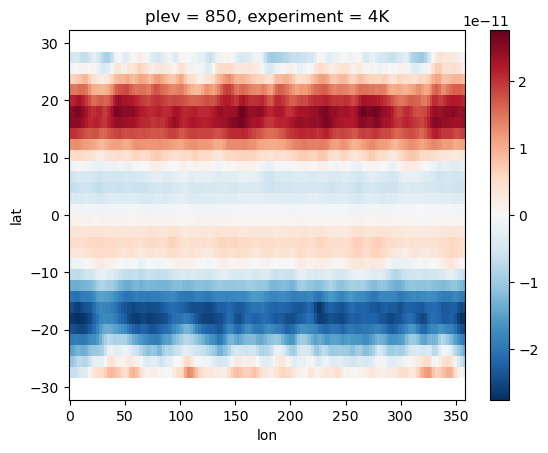

In [17]:
vortex_stretching.sel(experiment='4K', plev=850).mean(dim='time').plot()

In [18]:
relative_vorticity

<xarray.DataArray 'Vorticity' (experiment: 3, time: 3648, lat: 34, lon: 144,
                               plev: 40)> Size: 17GB
array([[[[[ 1.70995948e-07,  3.31428074e-07,  2.39789031e-07, ...,
            5.95471341e-07,  5.81176707e-07,  5.44448552e-07],
          [ 1.51382940e-07,  2.67096810e-07,  2.09718904e-07, ...,
            5.51359922e-07,  5.51727758e-07,  5.33975624e-07],
          [ 1.40431626e-07,  1.78707447e-07,  1.54061377e-07, ...,
            5.11334637e-07,  5.13296136e-07,  5.06589186e-07],
          ...,
          [ 2.86803744e-07,  4.01772714e-07,  2.55604967e-07, ...,
            6.15574285e-07,  6.20294341e-07,  5.66558105e-07],
          [ 2.44915238e-07,  4.07838518e-07,  2.58760509e-07, ...,
            6.25457334e-07,  6.21270925e-07,  5.75717486e-07],
          [ 2.11933295e-07,  3.98367736e-07,  2.53401378e-07, ...,
            6.39916975e-07,  6.11074194e-07,  5.49502158e-07]],

         [[ 2.14674971e-07,  3.41878911e-07,  2.47878008e-07, ...,
            5.50425567e-07,  5.39099000e-07,  5.22643021e-07],
          [ 1.98704626e-07,  2.99678986e-07,  2.20351678e-07, ...,
            5.11673007e-07,  5.08357426e-07,  4.98693669e-07],
          [ 1.86096235e-07,  2.30278187e-07,  1.71008510e-07, ...,
            4.64365833e-07,  4.63009407e-07,  4.56453998e-07],
...
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]]]]])
Coordinates:
  * plev        (plev) int64 320B 25 50 75 100 125 150 ... 900 925 950 975 1000
  * lat         (lat) float64 272B -31.26 -29.37 -27.47 ... 27.47 29.37 31.26
  * lon         (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time        (time) object 29kB 0003-01-03 00:00:00 ... 0013-01-03 00:00:00
  * experiment  (experiment) <U3 36B '-4K' '0K' '4K'
Attributes:
    units:       s$^{-1}$
    short_name:  ζ
    file_id:     vorticity